<a href="https://colab.research.google.com/github/zirpe007/DAILY-DSA/blob/main/Copy_of_Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git


Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 4590, done.
remote: Total 4590 (delta 0), reused 0 (delta 0), pack-reused 4590 (from 1)
Receiving objects: 100% (4590/4590), 186.72 MiB | 21.14 MiB/s, done.
Resolving deltas: 100% (271/271), done.
Updating files: 100% (4155/4155), done.


In [ ]:
!ls Face-Mask-Detection


 app.py		        face_detector	      Readme_images
 CITATION.cff	        images		     'README - Korean.md'
 CODE_OF_CONDUCT.md     incep_v3_mask_model   README.md
 _config.yml	        LICENSE		      requirements.txt
 CONTRIBUTING.md        Logo		      ResNet50_v2
 css		        mask_detector.model   search.py
 dataset	        model2onnx.py	      train_mask_detector.py
 detect_mask_image.py   plot.png	      Windows_guide.md
 detect_mask_video.py   __pycache__


In [ ]:
%cd Face-Mask-Detection
!ls


/content/Face-Mask-Detection
 app.py		        face_detector	      Readme_images
 CITATION.cff	        images		     'README - Korean.md'
 CODE_OF_CONDUCT.md     incep_v3_mask_model   README.md
 _config.yml	        LICENSE		      requirements.txt
 CONTRIBUTING.md        Logo		      ResNet50_v2
 css		        mask_detector.model   search.py
 dataset	        model2onnx.py	      train_mask_detector.py
 detect_mask_image.py   plot.png	      Windows_guide.md
 detect_mask_video.py   __pycache__


In [ ]:
!python /content/Face-Mask-Detection/train_mask_detector.py \
  --dataset /content/Face-Mask-Detection/dataset \
  --model mask_detector.h5 \
  --plot plot.png


2025-09-15 15:30:02.541795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757950202.578206    2131 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757950202.589353    2131 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757950202.618653    2131 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757950202.618713    2131 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757950202.618724    2131 computation_placer.cc:177] computation placer alr

In [ ]:
!ls /content/Face-Mask-Detection/dataset


with_mask  without_mask


In [ ]:
# Imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import numpy as np
import os

# Dataset path
DATASET_PATH = "/content/Face-Mask-Detection/dataset"

# Hyperparameters
INIT_LR = 1e-4
EPOCHS = 5        # Use 5 first to test
BS = 16           # Smaller batch size for Colab GPU


In [ ]:
print("[INFO] loading images...")

imagePaths = list(paths.list_images(DATASET_PATH))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

# One-hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Train/test split
(trainX, testX, trainY, testY) = train_test_split(
    data, labels, test_size=0.20, stratify=labels, random_state=42)


[INFO] loading images...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)


In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze base model layers
for layer in baseModel.layers:
    layer.trainable = False

# Compile
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


/tmp/ipython-input-3976163338.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


[INFO] compiling model...


In [ ]:
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX)//BS,
    validation_data=(testX, testY),
    validation_steps=len(testX)//BS,
    epochs=EPOCHS
)


[INFO] training head...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 206s 977ms/step - accuracy: 0.7392 - loss: 0.5462 - val_accuracy: 0.9670 - val_loss: 0.1329
Epoch 2/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


204/204 ━━━━━━━━━━━━━━━━━━━━ 42s 202ms/step - accuracy: 0.8750 - loss: 0.2900 - val_accuracy: 0.9695 - val_loss: 0.1323
Epoch 3/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 216s 958ms/step - accuracy: 0.9731 - loss: 0.1187 - val_accuracy: 0.9756 - val_loss: 0.0886
Epoch 4/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 42s 202ms/step - accuracy: 0.9375 - loss: 0.0927 - val_accuracy: 0.9768 - val_loss: 0.0886
Epoch 5/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 208s 904ms/step - accuracy: 0.9729 - loss: 0.0890 - val_accuracy: 0.9756 - val_loss: 0.0820


In [ ]:
MODEL_PATH = "mask_detector.h5"
model.save(MODEL_PATH, save_format="h5")
print(f"[INFO] Model saved as {MODEL_PATH}")


[INFO] Model saved as mask_detector.h5


In [ ]:
import os
os.listdir()



['CONTRIBUTING.md',
 'face_detector',
 'ResNet50_v2',
 'images',
 'css',
 'incep_v3_mask_model',
 'detect_mask_video.py',
 'README - Korean.md',
 '.DS_Store',
 '.gitignore',
 'app.py',
 '.github',
 'detect_mask_image.py',
 'LICENSE',
 'plot.png',
 'model2onnx.py',
 'CITATION.cff',
 'requirements.txt',
 'mask_detector.h5',
 'train_mask_detector.py',
 'mask_detector.model',
 '_config.yml',
 'Readme_images',
 'CODE_OF_CONDUCT.md',
 'dataset',
 'search.py',
 'README.md',
 'Windows_guide.md',
 '.git',
 '__pycache__',
 'Logo']

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Screenshot from 2025-09-15 17-42-32.png to Screenshot from 2025-09-15 17-42-32.png
Saving mask7.png to mask7.png
Saving mask6.png to mask6.png
Saving mask.jpg to mask.jpg
Saving lena.jpg to lena.jpg


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from google.colab import files
from IPython.display import display, Image

# Load trained model
model = load_model("mask_detector.h5")

# Upload multiple images
uploaded = files.upload()

for filename in uploaded.keys():
    # Display the image
    display(Image(filename))

    # Preprocess
    image = load_img(filename, target_size=(224,224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0  # normalize

    # Predict
    pred = model.predict(image)
    class_idx = np.argmax(pred, axis=1)[0]
    class_map = {0: "with_mask", 1: "without_mask"}
    print(f"[INFO] Prediction for {filename}: {class_map[class_idx]} ({pred[0][class_idx]*100:.2f}%)\n")


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from google.colab import files
from IPython.display import display, Image

# Load trained model
model = load_model("mask_detector.h5")

# Upload multiple images
uploaded = files.upload()

for filename in uploaded.keys():
    # Display the image
    display(Image(filename))

    # Preprocess
    image = load_img(filename, target_size=(224,224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0  # normalize

    # Predict
    pred = model.predict(image)
    class_idx = np.argmax(pred, axis=1)[0]
    class_map = {0: "with_mask", 1: "without_mask"}
    print(f"[INFO] Prediction for {filename}: {class_map[class_idx]} ({pred[0][class_idx]*100:.2f}%)\n")


Saving Screenshot from 2025-09-15 17-42-32.png to Screenshot from 2025-09-15 17-42-32 (1).png
Saving mask7.png to mask7 (1).png
Saving mask6.png to mask6 (1).png
Saving mask.jpg to mask (1).jpg
Saving lena.jpg to lena (1).jpg
[INFO] Processing Screenshot from 2025-09-15 17-42-32 (1).png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


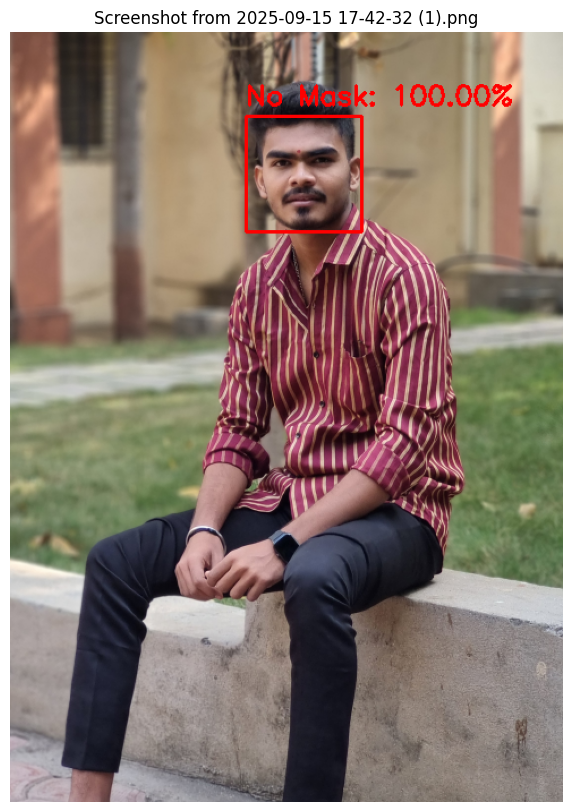

[INFO] Processing mask7 (1).png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


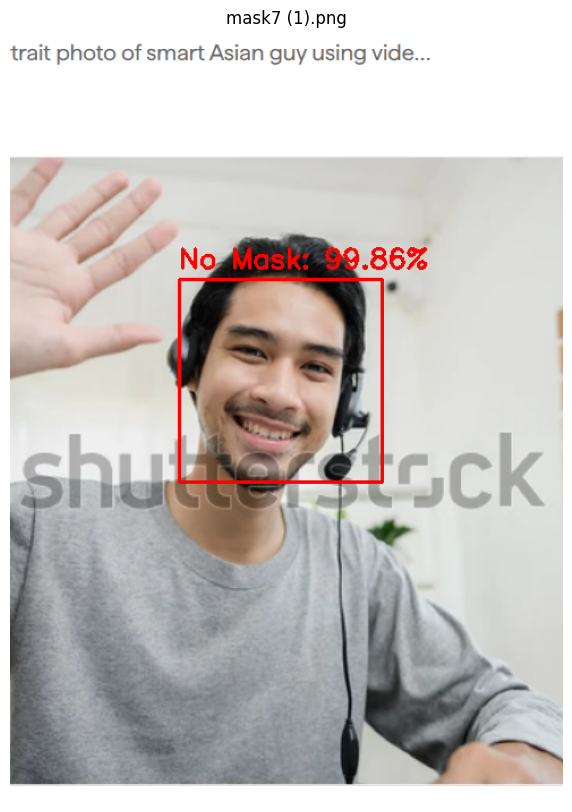

[INFO] Processing mask6 (1).png...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


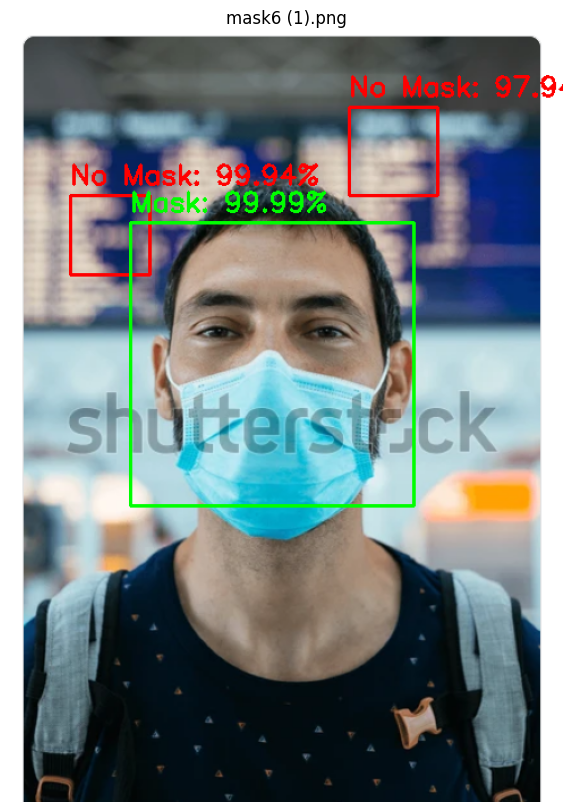

[INFO] Processing mask (1).jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


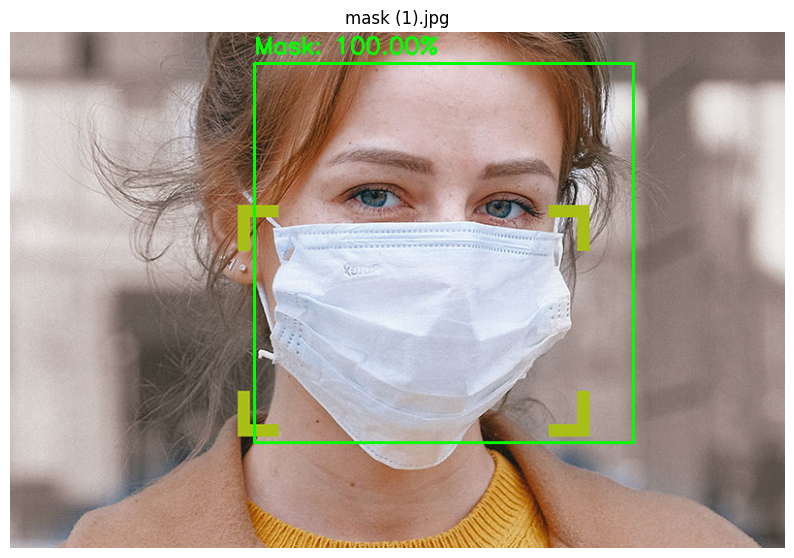

[INFO] Processing lena (1).jpg...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


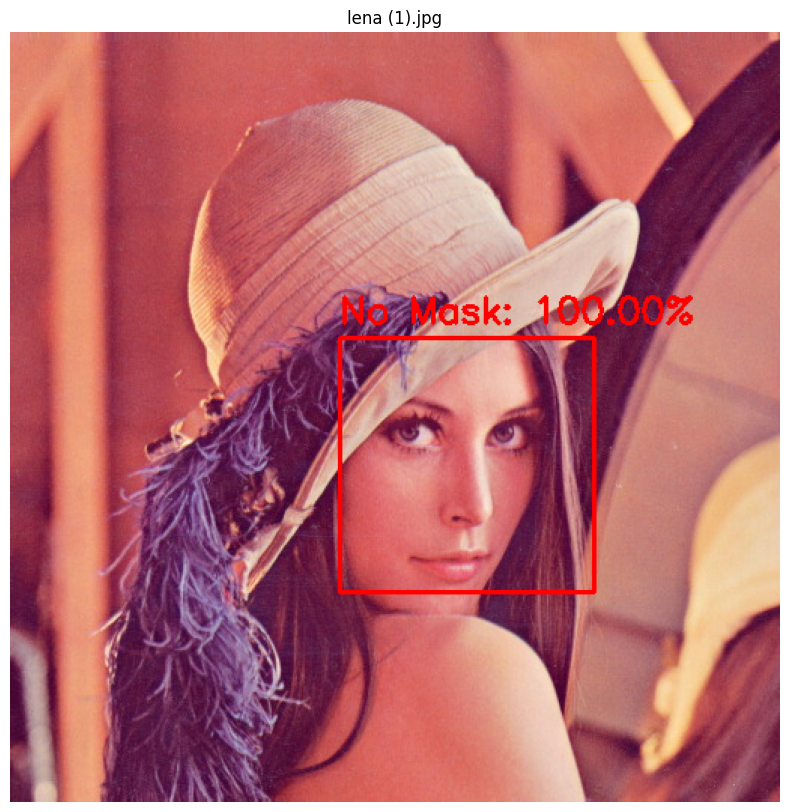

In [ ]:
# Install required packages if not already installed
!pip install opencv-python-headless

import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from google.colab import files
from matplotlib import pyplot as plt
import os

# Load your trained mask detector model
model = load_model("mask_detector.h5")

# Upload multiple images
uploaded = files.upload()

# Load OpenCV pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# Process each uploaded image
for filename in uploaded.keys():
    print(f"[INFO] Processing {filename}...")
    image = cv2.imread(filename)
    orig = image.copy()
    (h, w) = image.shape[:2]

    # Detect faces
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(60, 60))

    for (x, y, fw, fh) in faces:
        face = image[y:y+fh, x:x+fw]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)

        # Predict mask/no mask
        (mask, withoutMask) = model.predict(face)[0]
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        confidence = max(mask, withoutMask) * 100

        # Draw bounding box and label
        cv2.putText(image, f"{label}: {confidence:.2f}%", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        cv2.rectangle(image, (x, y), (x + fw, y + fh), color, 2)

    # Convert BGR to RGB for matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Show the output
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.title(filename)
    plt.show()
